In [ ]:
from os import getcwd
getcwd()

'/content'

<ipython-input-3-58800ffdc5d6>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq('MS')['aqi'].fillna(method='ffill')
<ipython-input-3-58800ffdc5d6>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq('MS')['aqi'].fillna(method='ffill')
<ipython-input-3-58800ffdc5d6>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq('MS')['aqi'].fillna(method='ffill')
<ipython-input-3-58800ffdc5d6>:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = group.set_index('date').asfreq('MS')['aqi'].fillna(method='ffill')
<ipython-input-3-58800ffdc5d6>:3

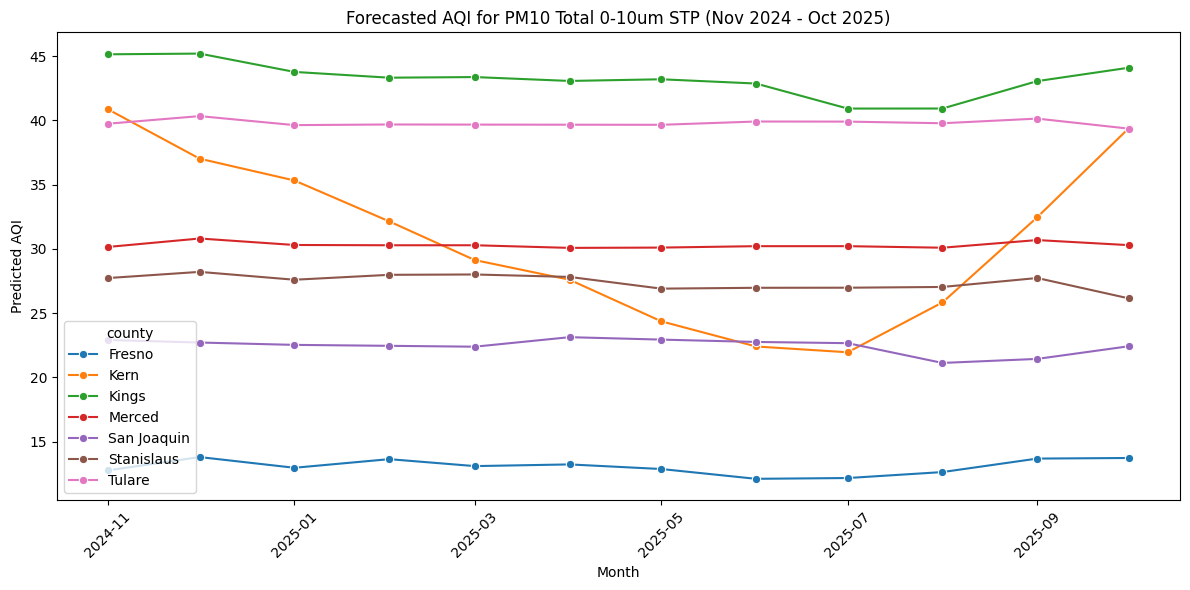

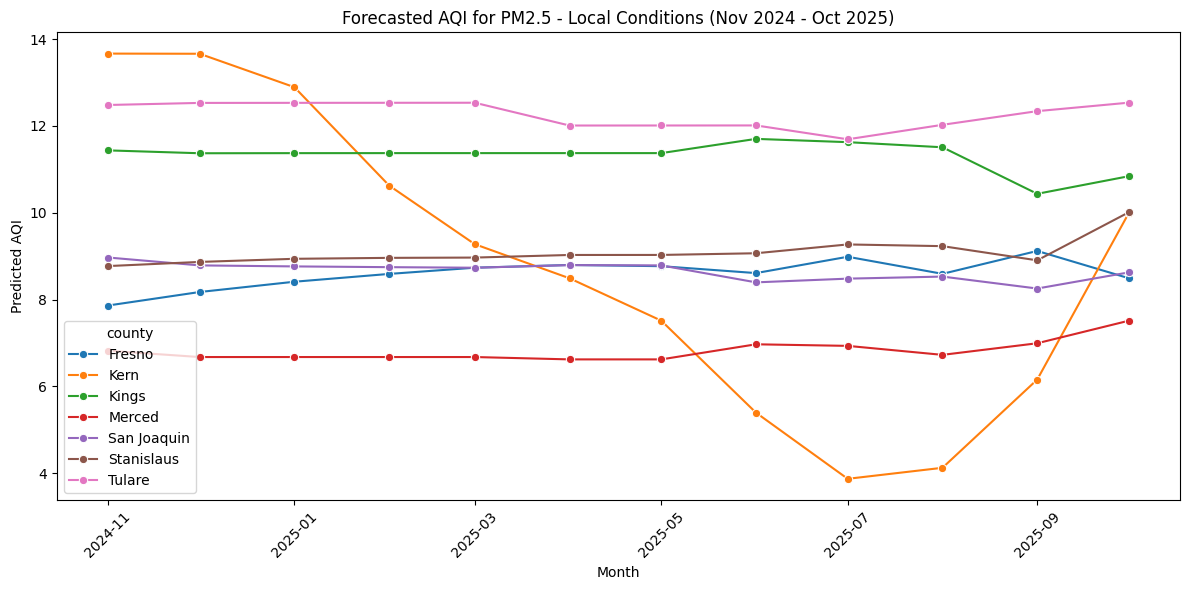

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your file (upload to Colab first)
df = pd.read_csv("SJV_AQI_1980_2025.csv")

# Filter to relevant counties, pollutants, and 'Daily Mean'
counties = ['San Joaquin', 'Stanislaus', 'Merced', 'Fresno', 'Kings', 'Tulare', 'Kern']
elements = ['PM10 Total 0-10um STP', 'PM2.5 - Local Conditions', 'Ozone', 'Nitrogen dioxide (NO2)']
df = df[df['county'].isin(counties) & df['parameter'].isin(elements)]
df = df[df['metric_used'] == 'Daily Mean']

# Combine to a datetime index for monthly mean AQI
df['year'] = df['year'].astype(str)
df['month'] = pd.to_datetime(df['first_max_datetime'], errors='coerce').dt.month
df['month'] = df['month'].fillna(1).astype(int)
df['date'] = pd.to_datetime(df['year'] + '-' + df['month'].astype(str) + '-01')

# Group and prepare data
grouped = df.groupby(['county', 'parameter', 'date'])['arithmetic_mean'].mean().reset_index()
grouped = grouped.rename(columns={'parameter': 'pollutant', 'arithmetic_mean': 'aqi'})

# Forecasting loop
results = []
future_months = pd.date_range("2024-11-01", "2025-10-01", freq='MS')

for (county, pollutant), group in grouped.groupby(['county', 'pollutant']):
    ts = group.set_index('date').asfreq('MS')['aqi'].fillna(method='ffill')
    if len(ts.dropna()) < 36:
        continue  # Skip if not enough data
    try:
        model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
        results_fit = model.fit(disp=False)
        forecast = results_fit.predict(start=len(ts), end=len(ts)+11)
        forecast = pd.DataFrame({
            'date': future_months,
            'predicted_aqi': forecast.values,
            'county': county,
            'pollutant': pollutant
        })
        results.append(forecast)
    except:
        continue

forecast_df = pd.concat(results)

# Save to CSV
forecast_df.to_csv("SJV_AQI_Predictions_2024_2025.csv", index=False)

# Plotting
for pollutant in forecast_df['pollutant'].unique():
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=forecast_df[forecast_df['pollutant'] == pollutant],
                 x='date', y='predicted_aqi', hue='county', marker='o')
    plt.title(f"Forecasted AQI for {pollutant} (Nov 2024 - Oct 2025)")
    plt.xticks(rotation=45)
    plt.ylabel("Predicted AQI")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.show()


# Other Pollutants

In [ ]:
# Step 1: Downgrade numpy to a compatible version (pmdarima expects <=1.26.x)
!pip install numpy==1.26.4 --force-reinstall

# Step 2: Reinstall pmdarima (recompiled with new numpy)
!pip install --force-reinstall --no-cache-dir pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 214.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 228.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 266.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 203.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 195.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 

In [ ]:
# STEP 1: Install dependencies (run this only once)
!pip install pmdarima matplotlib pandas

# STEP 2: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# STEP 3: Upload your CSV file
from google.colab import files
uploaded = files.upload()

# STEP 4: Read the CSV into a DataFrame
df = pd.read_csv("SJV_AQI_1980_2025.csv")

# STEP 5: Filter relevant data
counties = ['San Joaquin', 'Stanislaus', 'Merced', 'Fresno', 'Kings', 'Tulare', 'Kern']
pollutants = ['PM10 Total 0-10um STP', 'PM2.5 - Local Conditions', 'Ozone', 'Nitrogen dioxide (NO2)']
df = df[df['metric_used'] == 'Daily Mean']
filtered_df = df[df['county'].isin(counties) & df['parameter'].isin(pollutants)]

# STEP 6: Aggregate yearly AQI
grouped = filtered_df.groupby(['year', 'parameter'])['arithmetic_mean'].mean().reset_index()

# STEP 7: Create SARIMA model per pollutant
forecast_df = pd.DataFrame()

for param in pollutants:
    data = grouped[grouped['parameter'] == param].set_index('year').sort_index()
    data.index = pd.to_datetime(data.index, format="%Y")

    # Fit SARIMA automatically
    model = auto_arima(data['arithmetic_mean'], seasonal=True, m=12, suppress_warnings=True, stepwise=True)

    # Forecast for 12 future months
    sarima = SARIMAX(data['arithmetic_mean'], order=model.order, seasonal_order=model.seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
    results = sarima.fit()
    forecast = results.get_forecast(steps=12)
    predicted_mean = forecast.predicted_mean

    # Store forecast in DataFrame
    forecast_df[param] = predicted_mean.values

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(data.index, data['arithmetic_mean'], label='Historical')
    plt.plot(pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M'),
             predicted_mean, label='Forecast')
    plt.title(f"{param} Forecast (SARIMA)")
    plt.xlabel("Year")
    plt.ylabel("AQI")
    plt.legend()
    plt.grid(True)
    plt.show()

# STEP 8: View Forecast Table
forecast_df.index = pd.date_range(start="2024-11-01", periods=12, freq='M')
forecast_df


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject